# Multi-class

### Without Matrices, JUST ACCURACY - MULTICLASS

888

Accuracy (synthetic label & excluded problematic rows): 11.261%  (100/888 correct)


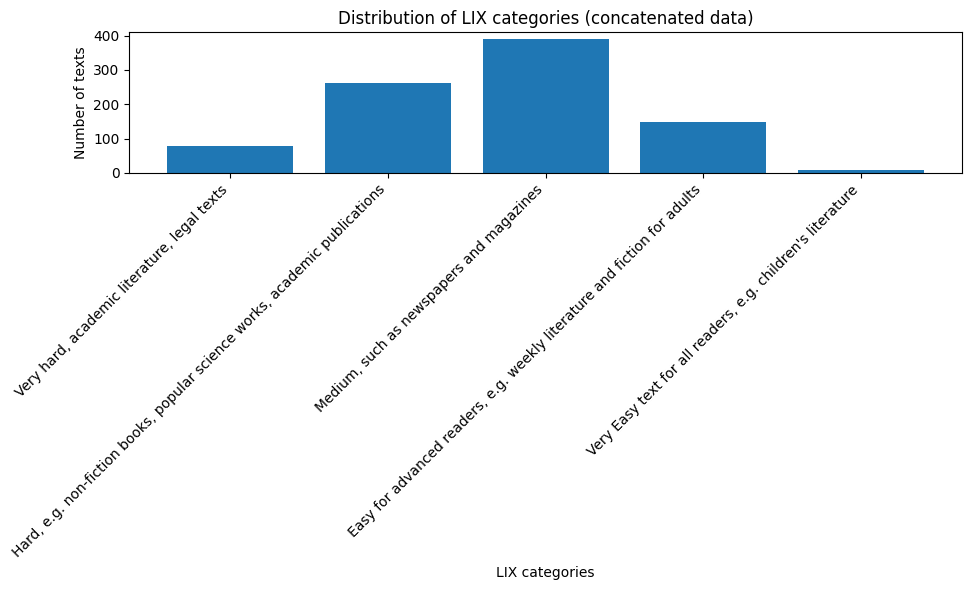

In [ ]:
import ast
import re
from collections import Counter
from pathlib import Path
from typing import List
import matplotlib.pyplot as plt
import pandas as pd
#########
# DATASET = pd.read_parquet("hf://datasets/data-is-better-together/fineweb-c/dan_Latn/train-00000-of-00001.parquet")
DATASET = pd.read_csv("Enhancing-Multilingual-AI-Analyzing-and-Modeling-Educational-Content-with-the-FineWeb-C/annotations Data/fineweb-c_relabled.csv")
DATASET["educational_value_labels"] = DATASET["educational_value_labels"].apply(ast.literal_eval)

PROBLEMATIC_CONTENT = False
ex_Data_path = "Enhancing-Multilingual-AI-Analyzing-and-Modeling-Educational-Content-with-the-FineWeb-C/annotations Data/fineweb2_data.csv"
#########


df = pd.DataFrame()
df["text"] = DATASET["text"]
df["educational_value_labels"] = DATASET["educational_value_labels"]
df["problematic_content_label_present"] = DATASET["problematic_content_label_present"]

extra_df = pd.read_csv(ex_Data_path)
extra_df = extra_df.rename(columns={"label": "educational_value_labels"})
extra_df['educational_value_labels'] = extra_df['educational_value_labels'].apply(ast.literal_eval)
extra_df['problematic_content_label_present'] = False

df = pd.concat([df, extra_df], ignore_index=True)

df = df[df['problematic_content_label_present'] == False]
print(len(df))

PRIORITY_ORDER = ["Excellent", "Good", "Basic", "Minimal", "None", "❗ Problematic Content ❗"]

def Most_common_label(labels):
    counts = Counter(labels)
    max_cnt = max(counts.values())
    candidates = [lab for lab, c in counts.items() if c == max_cnt]
    candidates.sort(key=lambda lab: PRIORITY_ORDER.index(lab))
    return candidates[0]

df["single_label"] = df["educational_value_labels"].apply(Most_common_label)

def compute_lix(text: str) -> float:
    sentences = [s.strip() for s in re.split(r"[.!?]+", text) if s.strip()]
    n_sent = len(sentences) or 1
    words = re.findall(r"\w+", text)
    n_words = len(words)
    n_long = sum(1 for w in words if len(w) > 6)
    return (n_words / n_sent) + (n_long * 100 / n_words) if n_words else 0

def lix_category(lix: float) -> str:
    if lix >= 55:
        return "Very hard, academic literature, legal texts"
    elif lix >= 45:
        return "Hard, e.g. non-fiction books, popular science works, academic publications"
    elif lix >= 35:
        return "Medium, such as newspapers and magazines"
    elif lix >= 25:
        return "Easy for advanced readers, e.g. weekly literature and fiction for adults"
    else:
        return "Very Easy text for all readers, e.g. children's literature"

df["lix"] = df["text"].apply(compute_lix)
df["lix_category"] = df["lix"].apply(lix_category)

CATEGORY_TO_EXPECTED_LABEL = {
    "Very hard, academic literature, legal texts": "Excellent",
    "Hard, e.g. non-fiction books, popular science works, academic publications": "Good",
    "Medium, such as newspapers and magazines": "Basic",
    "Easy for advanced readers, e.g. weekly literature and fiction for adults": "Minimal",
    "Very Easy text for all readers, e.g. children's literature": "None",
}

df["expected_label"] = df["lix_category"].map(CATEGORY_TO_EXPECTED_LABEL)


mask_problematic = (
    df["problematic_content_label_present"]
          .fillna(False)
          .astype(bool)
)

# choose whether to keep the problematic rows
mask_valid = (
    ~df["problematic_content_label_present"].fillna(False)
    if not PROBLEMATIC_CONTENT          # exclude them
    else pd.Series(True, index=df.index)  # include them
)

mask_non_synth = df["single_label"] != "❗ Problematic Content ❗"
mask_final     = mask_valid & mask_non_synth      # both sides are Boolean Series
# Only mask for non-synthetic labels, since problematic rows are already excluded
mask_final = df["single_label"] != "❗ Problematic Content ❗"


correct = (
    df.loc[mask_final, "single_label"]
           .eq(df.loc[mask_final, "expected_label"])
           .sum()
)
total = mask_final.sum()
accuracy = correct / total if total else 0.0

print(
    f"\nAccuracy (synthetic label & "
    f"{'included' if PROBLEMATIC_CONTENT else 'excluded'} problematic rows): "
    f"{accuracy:.3%}  ({correct}/{total} correct)"
)
ordered_cats = list(CATEGORY_TO_EXPECTED_LABEL.keys())
cat_counts = df.loc[mask_valid, "lix_category"].value_counts() \
                    .reindex(ordered_cats, fill_value=0)

plt.figure(figsize=(10, 6))
plt.bar(cat_counts.index, cat_counts.values)
plt.xlabel("LIX categories")
plt.ylabel("Number of texts")
plt.title("Distribution of LIX categories (concatenated data)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### With Matrices - MULTICLASS

CONFUSION MATRIX


C:\Users\will2\AppData\Local\Temp\ipykernel_8544\1445729012.py:93: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)


Predicted (LIX),Excellent,Good,Basic,Minimal,None
Actual (Human),,,,,
Excellent,0,1,2,1,0
Good,0,5,5,1,0
Basic,8,26,26,6,0
Minimal,27,92,143,43,0
None,29,107,184,94,6



PER-LABEL ACCURACY


,accuracy
Actual (Human),
Excellent,0.000
Good,0.455
Basic,0.394
Minimal,0.141
None,0.014


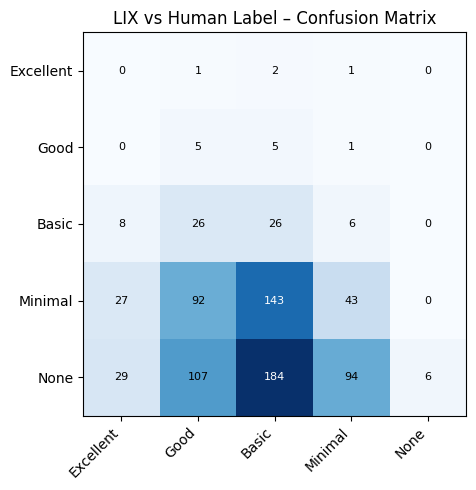

In [ ]:
import ast
import re
from collections import Counter
from pathlib import Path
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_FILES: List[Path] = [
    Path("Enhancing-Multilingual-AI-Analyzing-and-Modeling-Educational-Content-with-the-FineWeb-C/annotations Data/fineweb-c_relabled.csv"),
    Path("Enhancing-Multilingual-AI-Analyzing-and-Modeling-Educational-Content-with-the-FineWeb-C/annotations Data/fineweb2_data.csv"),
]

PROBLEMATIC_CONTENT = False
PRIORITY_ORDER = ["Excellent", "Good", "Basic", "Minimal", "None",
                  "❗ Problematic Content ❗"]

frames = []
for f in DATA_FILES:
    if f.suffix == ".csv":
        frames.append(pd.read_csv(f))
    elif f.suffix == ".parquet":
        frames.append(pd.read_parquet(f))
    else:
        raise ValueError(f"Unsupported file type: {f}")
df = pd.concat(frames, ignore_index=True)


if "label" in df.columns and "educational_value_labels" not in df.columns:
    df = df.rename(columns={"label": "educational_value_labels"})
if "problematic_content_label_present" not in df.columns:
    df["problematic_content_label_present"] = False

def parse_label_list(cell):
    if isinstance(cell, list):
        return cell
    if isinstance(cell, str):
        try:
            return ast.literal_eval(cell)
        except Exception:
            return [p.strip(" []'\"") for p in cell.split(",") if p.strip()]
    return []

df["educational_value_labels"] = df["educational_value_labels"].apply(parse_label_list)

def most_common_label(labels):
    if not labels:
        return "❗ Problematic Content ❗"
    counts = Counter(labels)
    max_cnt = max(counts.values())
    winners = [lab for lab, c in counts.items() if c == max_cnt]
    winners.sort(key=lambda lab: PRIORITY_ORDER.index(lab))
    return winners[0]

df["single_label"] = df["educational_value_labels"].apply(most_common_label)

def compute_lix(text: str) -> float:
    sentences = [s.strip() for s in re.split(r"[.!?]+", text) if s.strip()]
    n_sent = len(sentences) or 1
    words = re.findall(r"\w+", text)
    n_words = len(words)
    n_long = sum(1 for w in words if len(w) > 6)
    return (n_words / n_sent) + (n_long * 100 / n_words) if n_words else 0

def lix_category(lix: float) -> str:
    if lix >= 55:
        return "Meget svær, faglitteratur på akademisk niveau, lovtekster"
    elif lix >= 45:
        return "Svær, f.eks. saglige bøger, populærvidenskabelige værker, akademiske udgivelser"
    elif lix >= 35:
        return "Middel, f.eks. dagblade og tidsskrifter"
    elif lix >= 25:
        return "Let for øvede læsere, f.eks. ugebladslitteratur og skønlitteratur for voksne"
    else:
        return "Let tekst for alle læsere, f.eks. børnelitteratur"

df["lix"] = df["text"].apply(compute_lix)
df["lix_category"] = df["lix"].apply(lix_category)

CATEGORY_TO_EXPECTED_LABEL = {
    "Meget svær, faglitteratur på akademisk niveau, lovtekster": "Excellent",
    "Svær, f.eks. saglige bøger, populærvidenskabelige værker, akademiske udgivelser": "Good",
    "Middel, f.eks. dagblade og tidsskrifter": "Basic",
    "Let for øvede læsere, f.eks. ugebladslitteratur og skønlitteratur for voksne": "Minimal",
    "Let tekst for alle læsere, f.eks. børnelitteratur": "None",
}
df["expected_label"] = df["lix_category"].map(CATEGORY_TO_EXPECTED_LABEL)


mask_problem = (
    df["problematic_content_label_present"]
      .fillna(False)
      .astype(bool)
)
mask_valid = slice(None) if PROBLEMATIC_CONTENT else ~mask_problem
mask_non_synth = df["single_label"] != "❗ Problematic Content ❗"
mask_eval = mask_valid & mask_non_synth

eval_df = df.loc[mask_eval, ["single_label", "expected_label"]]


ordered = PRIORITY_ORDER[:-1]
confusion = pd.crosstab(
    eval_df["single_label"],
    eval_df["expected_label"],
    rownames=["Actual (Human)"],
    colnames=["Predicted (LIX)"],
    dropna=False,
).reindex(index=ordered, columns=ordered, fill_value=0)

per_label_acc = (np.diag(confusion) / confusion.sum(axis=1)).round(3)
per_label_acc = per_label_acc.to_frame("accuracy")

print("CONFUSION MATRIX")
display(confusion)
print("\nPER-LABEL ACCURACY")
display(per_label_acc)


plt.figure(figsize=(7, 5))
plt.imshow(confusion, cmap="Blues")
plt.title("LIX vs Human Label – Confusion Matrix")
plt.xticks(ticks=range(len(ordered)), labels=ordered, rotation=45, ha="right")
plt.yticks(ticks=range(len(ordered)), labels=ordered)
for i in range(len(ordered)):
    for j in range(len(ordered)):
        plt.text(j, i, confusion.iat[i, j],
                 ha="center", va="center",
                 color="black" if confusion.iat[i, j] < confusion.values.max()*0.6 else "white",
                 fontsize=8)
plt.tight_layout()
plt.show()


# Binary

### Without Matrices, JUST ACCURACY - BINARY


Binary accuracy (method 2): 44.482% (395/888)

Confusion matrix (counts)
                    Pred Educational  Pred No value
Actual Educational               386              0
Actual No value                  493              9


/var/folders/z5/n4953y3d781810x5g1_db6b00000gn/T/ipykernel_91813/3726303241.py:120: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)


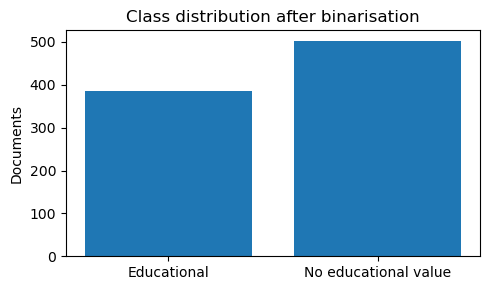

In [ ]:
import ast
import re
from collections import Counter
from pathlib import Path
from typing import List
import pandas as pd
import matplotlib.pyplot as plt

DATA_FILES: List[Path] = [
    Path("Enhancing-Multilingual-AI-Analyzing-and-Modeling-Educational-Content-with-the-FineWeb-C/annotations Data/fineweb-c_relabled.csv"),
    Path("Enhancing-Multilingual-AI-Analyzing-and-Modeling-Educational-Content-with-the-FineWeb-C/annotations Data/fineweb2_data.csv"),
]

PROBLEMATIC_CONTENT = False

PRIORITY_ORDER = ["Excellent", "Good", "Basic", "Minimal",
                  "None", "❗ Problematic Content ❗"]


frames = []
for f in DATA_FILES:
    if f.suffix == ".csv":
        frames.append(pd.read_csv(f))
    elif f.suffix == ".parquet":
        frames.append(pd.read_parquet(f))
    else:
        raise ValueError(f"Unsupported file type: {f}")

df = pd.concat(frames, ignore_index=True)


if "label" in df.columns and "educational_value_labels" not in df.columns:
    df = df.rename(columns={"label": "educational_value_labels"})
if "problematic_content_label_present" not in df.columns:
    df["problematic_content_label_present"] = False


def parse_label_list(cell):
    if isinstance(cell, list):
        return cell
    if isinstance(cell, str):
        try:
            return ast.literal_eval(cell)
        except Exception:
            return [p.strip(" []'\"") for p in cell.split(",") if p.strip()]
    return []

df["educational_value_labels"] = df["educational_value_labels"].apply(parse_label_list)


def most_common_label(labels):
    if not labels:
        return "❗ Problematic Content ❗"
    counts = Counter(labels)
    max_cnt = max(counts.values())
    winners = [lbl for lbl, c in counts.items() if c == max_cnt]
    winners.sort(key=lambda lbl: PRIORITY_ORDER.index(lbl))
    return winners[0]

df["single_label"] = df["educational_value_labels"].apply(most_common_label)

def compute_lix(text: str) -> float:
    sentences = [s.strip() for s in re.split(r"[.!?]+", text) if s.strip()]
    n_sent = len(sentences) or 1
    words = re.findall(r"\w+", text)
    n_words = len(words)
    n_long = sum(1 for w in words if len(w) > 6)
    return (n_words / n_sent) + (n_long * 100 / n_words) if n_words else 0

def lix_category(lix: float) -> str:
    if lix >= 55:
        return "Meget svær, faglitteratur på akademisk niveau, lovtekster"
    elif lix >= 45:
        return "Svær, f.eks. saglige bøger, populærvidenskabelige værker, akademiske udgivelser"
    elif lix >= 35:
        return "Middel, f.eks. dagblade og tidsskrifter"
    elif lix >= 25:
        return "Let for øvede læsere, f.eks. ugebladslitteratur og skønlitteratur for voksne"
    else:
        return "Let tekst for alle læsere, f.eks. børnelitteratur"

df["lix"] = df["text"].apply(compute_lix)
df["lix_category"] = df["lix"].apply(lix_category)


educational_set = {"Minimal", "Basic", "Good", "Excellent"}
no_value_set    = {"None", "❗ Problematic Content ❗"}

def collapse_to_binary(lbl):
    return "Educational" if lbl in educational_set else "No educational value"

df["human_binary"] = df["single_label"].apply(collapse_to_binary)


def lix_binary(cat):
    return "Educational" if cat != "Let tekst for alle læsere, f.eks. børnelitteratur" else "No educational value"

df["pred_binary"] = df["lix_category"].apply(lix_binary)


mask_problem = (
    df["problematic_content_label_present"]
      .fillna(False)
      .astype(bool)
)
mask_valid = slice(None) if PROBLEMATIC_CONTENT else ~mask_problem
mask_final = mask_valid

eval_df = df.loc[mask_final, ["human_binary", "pred_binary"]]


tp = ((eval_df["human_binary"] == "Educational") &
      (eval_df["pred_binary"]  == "Educational")).sum()
tn = ((eval_df["human_binary"] == "No educational value") &
      (eval_df["pred_binary"]  == "No educational value")).sum()
fp = ((eval_df["human_binary"] == "No educational value") &
      (eval_df["pred_binary"]  == "Educational")).sum()
fn = ((eval_df["human_binary"] == "Educational") &
      (eval_df["pred_binary"]  == "No educational value")).sum()

accuracy = (tp + tn) / len(eval_df) if len(eval_df) else 0.0

print(f"\nBinary accuracy (method 2): {accuracy:.3%} ({tp+tn}/{len(eval_df)})")
print("\nConfusion matrix (counts)")
print(pd.DataFrame(
    [[tp, fn],
     [fp, tn]],
    index=["Actual Educational", "Actual No value"],
    columns=["Pred Educational", "Pred No value"]
))

plt.figure(figsize=(5, 3))
plt.bar(["Educational", "No educational value"],
        eval_df["human_binary"].value_counts().reindex(["Educational", "No educational value"]))
plt.ylabel("Documents")
plt.title("Class distribution after binarisation")
plt.tight_layout()
plt.show()



Binary accuracy (method 2): 48.635% (392/806)

Confusion matrix (counts)
                    Pred Educational  Pred No value
Actual Educational               386              0
Actual No value                  414              6

Per-label recall
                      recall
Educational            1.000
No educational value   0.014


/var/folders/z5/n4953y3d781810x5g1_db6b00000gn/T/ipykernel_91813/4139303439.py:121: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask_problem_flag = df["problematic_content_label_present"].fillna(False).astype(bool)


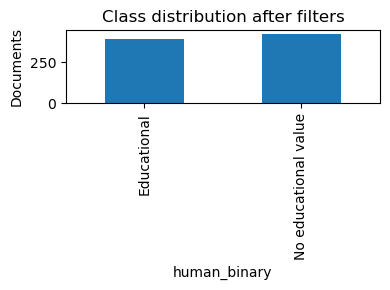

In [ ]:

import ast
import re
from collections import Counter
from pathlib import Path
from typing import List

import pandas as pd
import matplotlib.pyplot as plt


DATA_FILES: List[Path] = [
    Path("Enhancing-Multilingual-AI-Analyzing-and-Modeling-Educational-Content-with-the-FineWeb-C/annotations Data/fineweb-c_relabled.csv"),
    Path("Enhancing-Multilingual-AI-Analyzing-and-Modeling-Educational-Content-with-the-FineWeb-C/annotations Data/fineweb2_data.csv"),
]

PRIORITY_ORDER = ["Excellent", "Good", "Basic", "Minimal",
                  "None", "❗ Problematic Content ❗"]


frames = []
for f in DATA_FILES:
    frames.append(pd.read_csv(f) if f.suffix == ".csv" else pd.read_parquet(f))
df = pd.concat(frames, ignore_index=True)


if "label" in df.columns and "educational_value_labels" not in df.columns:
    df = df.rename(columns={"label": "educational_value_labels"})
if "problematic_content_label_present" not in df.columns:
    df["problematic_content_label_present"] = False


def parse_list(cell):
    if isinstance(cell, list):
        return cell
    if isinstance(cell, str):
        try:
            return ast.literal_eval(cell)
        except Exception:
            return [p.strip(" []'\"") for p in cell.split(",") if p.strip()]
    return []

df["educational_value_labels"] = df["educational_value_labels"].apply(parse_list)


def collapse_majority(labels):
    if not labels:
        return "❗ Problematic Content ❗"
    cnt = Counter(labels)
    max_cnt = max(cnt.values())
    candidates = [l for l, c in cnt.items() if c == max_cnt]
    candidates.sort(key=lambda l: PRIORITY_ORDER.index(l))
    return candidates[0]

df["single_label"] = df["educational_value_labels"].apply(collapse_majority)


def compute_lix(text):
    sentences = [s.strip() for s in re.split(r"[.!?]+", text) if s.strip()]
    n_sent = len(sentences) or 1
    words = re.findall(r"\w+", text)
    n_words = len(words)
    n_long = sum(len(w) > 6 for w in words)
    return (n_words / n_sent) + (n_long * 100 / n_words) if n_words else 0

def lix_category(lix):
    if lix >= 55:
        return "Meget svær, faglitteratur på akademisk niveau, lovtekster"
    if lix >= 45:
        return "Svær, f.eks. saglige bøger, populærvidenskabelige værker, akademiske udgivelser"
    if lix >= 35:
        return "Middel, f.eks. dagblade og tidsskrifter"
    if lix >= 25:
        return "Let for øvede læsere, f.eks. ugebladslitteratur og skønlitteratur for voksne"
    return "Let tekst for alle læsere, f.eks. børnelitteratur"

df["lix"] = df["text"].apply(compute_lix)
df["lix_category"] = df["lix"].apply(lix_category)


educational_set = {"Minimal", "Basic", "Good", "Excellent"}
def to_binary(lbl):
    return "Educational" if lbl in educational_set else "No educational value"

df["human_binary"] = df["single_label"].apply(to_binary)
df["pred_binary"] = df["lix_category"].apply(
    lambda c: "Educational" if c != "Let tekst for alle læsere, f.eks. børnelitteratur"
    else "No educational value"
)


mask_problem_flag = df["problematic_content_label_present"].fillna(False).astype(bool)
mask_non_synth    = df["single_label"] != "❗ Problematic Content ❗"
eval_df = df.loc[~mask_problem_flag & mask_non_synth,
                 ["human_binary", "pred_binary"]]


tp = ((eval_df.human_binary == "Educational") & (eval_df.pred_binary == "Educational")).sum()
tn = ((eval_df.human_binary == "No educational value") & (eval_df.pred_binary == "No educational value")).sum()
fp = ((eval_df.human_binary == "No educational value") & (eval_df.pred_binary == "Educational")).sum()
fn = ((eval_df.human_binary == "Educational") & (eval_df.pred_binary == "No educational value")).sum()

accuracy = (tp + tn) / len(eval_df)

print(f"\nBinary accuracy (method 2): {accuracy:.3%} ({tp+tn}/{len(eval_df)})")

conf_mat = pd.DataFrame(
    [[tp, fn],
     [fp, tn]],
    index=["Actual Educational", "Actual No value"],
    columns=["Pred Educational", "Pred No value"]
)
print("\nConfusion matrix (counts)")
print(conf_mat)

per_label_recall = pd.Series({
    "Educational": tp / (tp + fn) if tp + fn else 0.0,
    "No educational value": tn / (tn + fp) if tn + fp else 0.0
}).round(3).to_frame("recall")

print("\nPer-label recall")
print(per_label_recall)

plt.figure(figsize=(4, 3))
eval_df["human_binary"].value_counts().reindex(
    ["Educational", "No educational value"]).plot.bar()
plt.ylabel("Documents")
plt.title("Class distribution after filters")
plt.tight_layout()
plt.show()
